# Cuaderno 5: Perceptrones

Los perceptrones fue el nombre genérico dado por el psicólogo Frank Rosenblatt a una familia de modelos teóricos y experimentales de redes neuronales artificiales que propuso entre 1957 y 1962. El trabajo de Rosenblatt generó mucha emoción, controversia e interés en los modelos de redes neuronales para la clasificación de patrones durante ese periodo, y dio lugar a importantes modelos abstractos basados en su trabajo en años posteriores. Actualmente, los nombres *perceptrón* (de una sola capa) y *perceptrón multicapa* se utilizan para referirse a estructuras específicas de redes neuronales artificiales basadas en los perceptrones de Rosenblatt.

Los orígenes de las redes neuronales se encuentran en la neurona de McCulloch-Pitts (McCulloch y Pitts, 1943), un modelo simplificado de la neurona biológica como un tipo de elemento de computación que podía describirse en términos de lógica proposicional. Sin embargo, el uso moderno ya no se basa tanto en estas primeras inspiraciones biológicas.

En cambio, una red neuronal moderna es una red de pequeñas unidades de computación, cada una de las cuales toma un vector de valores de entrada y produce un único valor de salida. En este cuaderno, introducimos el perceptrón simple y el perceptrón multicapa, como nuestra primera aproximación a redes neuronales aplicadas a la clasificación. La arquitectura que presentamos se llama red de retroalimentación (*feedforward*) porque el cálculo avanza de manera iterativa de una capa de unidades a la siguiente (lo veremos en el perceptrón multicapa). El uso de redes neuronales modernas se conoce a menudo como aprendizaje profundo (*deep learning*), ya que las redes modernas suelen ser profundas (tienen muchas capas).

Las redes neuronales comparten gran parte de la misma matemática que la regresión logística. Sin embargo, las redes neuronales son un clasificador más poderoso que la regresión logística, y de hecho, se puede demostrar que una red neuronal mínima (técnicamente, una con una sola capa oculta) puede aprender cualquier función.

Como es usual, comenzamos importando las librerías que vamos a utilizar.

## Configuración

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets

### Funciones de graficado

In [95]:
def visualizar_errores(t, errors, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(t, errors)
    ax.set_ylim(-2, 2)
    ax.set_xlabel("Iteración")
    ax.set_ylabel("Error")
    ax.axhline(0, color='r')

def visualizar_pesos(W, b, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # Dibujar la recta de decisión
    x_vals = np.linspace(-1, 1, 100)
    if W[1] != 0:
        y_vals = -(W[0] * x_vals + b) / W[1]
        ax.plot(x_vals, y_vals, 'r--')
    else:
        x0 = -b / W[0]
        ax.axvline(x0, color='r', linestyle='--')

    # Configurar los ejes
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.axhline(0, color='black', linewidth=0.5)
    ax.axvline(0, color='black', linewidth=0.5)
    ax.set_aspect('equal')
    ax.set_title(f"Límite de decisión")

## Perceptrón simple

El primer problema de nuestro perceptrón va a ser el de aprender a imitar una compuerta lógica OR. Las compuertas lógicas OR son dispositivos electrónicos con una función booleana OR, a partir de dos señales de entrada, detectan cuando al menos una de ellas esta prendida. El objetivo del perceptrón va a ser, a partir de dos entradas binarias y una salida esperada (que va a tomar 1 cuando una de las dos entradas tiene el valor de 1), entender la lógica que estamos queriendo que aprenda y modificar los pesos de su capa de activación de forma tal que, luego de un número arbitrario de entrenamientos, estos pesos se establecen en un valor que resuelve siempre la función booleana.

En resumen, vamos a entrenar un perceptrón de dos nodos de entrada y uno de salida utilizando vectores de entrada $\pmb{X_1}$, $\pmb{X_2}$, $\pmb{X_3}$ y $\pmb{X_4}$ y cuatro vectores de salida esperados $\pmb{Y_1}$, $\pmb{Y_2}$, $\pmb{Y_3}$ y $\pmb{Y_4}$:

$$\begin{split}
\pmb{X_1} = \begin{pmatrix} 0 \\ 0 \end{pmatrix} & \pmb{Y_1} = \begin{pmatrix} 0 \end{pmatrix} \\
\pmb{X_2} = \begin{pmatrix} 0 \\ 1 \end{pmatrix} & \pmb{Y_2} = \begin{pmatrix} 1 \end{pmatrix} \\
\pmb{X_3} = \begin{pmatrix} 1 \\ 0 \end{pmatrix} & \pmb{Y_3} = \begin{pmatrix} 1 \end{pmatrix} \\
\pmb{X_4} = \begin{pmatrix} 1 \\ 1 \end{pmatrix} & \pmb{Y_4} = \begin{pmatrix} 1 \end{pmatrix}
\end{split}$$

Para aprovechar la ventaja que nos ofrecen las matrices, lo haremos definiendo dos matrices $\pmb{X}$ e $\pmb{Y}$ equivalentes:

$$\pmb{X} = \begin{pmatrix} 0 & 0 & 1 & 1 \\ 0 & 1 & 0 & 1 \end{pmatrix}$$

$$\pmb{Y} = \begin{pmatrix} 0 & 1 & 1 & 1 \end{pmatrix}$$

Como podran notar, $\pmb{X}$ tiene todas las posibles combinaciones de entradas. Además, la salida esperada $\pmb{Y}$ toma el valor de 1 cuando al menos uno de los nodos de entrada toma el valor de 1. Esto nos será útil para entrenar al perceptrón para realizar funciones de lógica binaria, como OR, ya que estaremos seguros de que el perceptrón pudo ver todas las posibilidades. Simplemente, lo que haremos será entrenarlo con todas las combinaciones una cantidad arbitraria $n$ de veces, y veremos como mejora en cada vez.

Un perceptrón simple tiene tres componentes:

- Una capa de entradas: Son los valores que alimentan al perceptrón. Cada entrada representa una característica distinta.
- Pesos: Cada entrada tiene un peso asociado que determina que tanta importancia tiene cada característica en la decisión final. Estos pesos se ajustan en la fase de entrenamiento.
- Función de activación: Después de calcular la suma ponderada $z$ de las entradas y los pesos, el resultado se pasa por una función de activación que decide si la neurona se activa o no, produciendo una salida $a$ que toma el valor de 0 o 1.

Los pesos de las entradas pueden modelarse con una matriz $\pmb{w}$ de forma tal que la suma ponderada cumpla con:

$$z = \pmb{w} \cdot \pmb{X} + b$$

En dónde $b$ es un término de sesgo que ayuda a ajustar el modelo y $z$ es la salida del perceptrón. El perceptrón simple, entonces, va a aprender a modificar los pesos y el término de sesgo de forma tal que la salida $Y$ se aproxime cada vez más a la salida $Y_0$ esperada.

Finalmente, en lugar de usar $z$, una función lineal de $x$, como salida, los perceptrones aplican una función de activación que indica cuando el perceptrón se activa, es decir, separa la $x$ en un 0 o un 1. Nos referiremos a la salida de esta función como el valor de activación para el perceptrón. Dado que estamos modelando un perceptrón simple, la activación del nodo de resultado es, de hecho, la salida final de la red, que generalmente llamaremos $y$. Así que el valor $y$ para un perceptrón simple de dos entradas $x_1$ y $x_2$ se define como:

$\hat{y} = \sigma(w_1 \times x_1 + w_2 \times x_2 + b)$

en donde $\sigma$ es la función de activación. Veámosla más en detalle.

### Función de activación $\sigma$

La función de activación transforma el resultado de multiplicar las entradas por los pesos en una forma binaria, de unos y ceros. Esto es lo que queremos cuando el objetivo del perceptrón es el de tomar una decisión binaria, como el de la clasificación.

Una función de activación comúnmente usada es la sigmoide (hay otras), que toma la forma:

$\sigma(x) = \dfrac{1}{1 + e^{- \beta x}}$

Esta función transforma la mayoria de los valores en 0 o en 1. Ejecutá la celda siguiente para verla en acción, y pensá:

- ¿Que ocurre cuando aumenta $\beta$?

In [6]:
def sigmoid(x, beta):
    return 1 / (1 + np.exp(-beta * x))

x = np.arange(-10, 10, 0.1)

@widgets.interact(beta=(0, 10, 0.01))
def simulate(beta):
    plt.plot(x, sigmoid(x, beta))
    plt.vlines(x=0, ymin=0, ymax=1, color='r', linestyles='--')

interactive(children=(FloatSlider(value=5.0, description='beta', max=10.0, step=0.01), Output()), _dom_classes…

Cuando $\beta$ tiende al infinito, la función sigmoide separa aún mejor los valores en ceros y unos. No obstante, en una computadora todavia persiste el problema de $x=0$, por lo que normalmente simplemente se transforma manualmente a 0 los valores menores o iguales a 0.5, y a 1 los valores mayores a 0.5 para evitar este problema.

### Compuerta OR

El entrenamiento del perceptrón se realiza utilizando un algoritmo conocido como regla de aprendizaje del perceptrón. Este ajusta los pesos basándose en el error de las predicciones, buscando minimizar la diferencia entre las salidas predichas y las reales. En la clase vimos como combinando el aprendizaje Hebbiano con la regla de la cadena podemos ir aproximandonos a los pesos que buscamos.

Veamos la implementación de un perceptrón simple y entrenémoslo para detectar la compuerta OR:

In [96]:
# Tiempo máximo que queremos entrenar
tmax = 1000

# Umbral de activación
threshold = 0.5

# Definimos el modelo lineal que queremos resolver
def z(x, w, b):
    return w.dot(x) + b

# Definimos la función de activación
def g(z):
    return 1 / (1 + np.exp(-z))

def y(X, W, b):
    return g(z(X, W, b))

# Definimos la derivada de la función de activación dy/dw
def dg(y):
    return y * (1 - y)

# Definimos la función que calcula el error
def loss(x, x_pred):
    return x - x_pred

# Definimos la cantidad de trials que vamos a usar
t = np.arange(tmax)

# Definimos la funcion que entrena un conjunto de datos de entrada y salida y grafica el error cometido
# en cada salto de tiempo.
# X: Las entradas del conjunto de entrenamiento
# Y: Las salidas esperadas del conjunto de entrenamiento
# alpha: Constante de aprendizaje
def perceptron_simple(X, Y, alpha=0.5):
    # Iniciamos un array que va a guardar los errores en cada paso para poder graficarlos al final
    # y observar como va aprendiendo el perceptrón en cada paso
    errors = []

    # Fijamos la semilla para reproducir siempre los mismos valores aleatorios
    np.random.seed(1) 
    
    # Iniciamos la matriz con los pesos en forma aleatoria
    W = np.random.randn(Y.shape[0], X.shape[0])

    # Iniciamos el término de sesgo con un número aleatorio
    b = np.random.uniform(-1, 1)

    for step in t:
        y_hat = y(X, W, b)
        error = loss(Y, y_hat)
        delta = error * dg(y_hat)
        W = W + alpha * delta.dot(X.T)
        b = b + alpha * delta.sum()

        errors = np.append(errors, np.sum(np.pow(error, 2)))

    # Graficamos el error
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
    visualizar_errores(t, errors, ax1)
    visualizar_pesos(W[0], b, ax2)
    plt.show()

    print(W)
    print(b)
    
    return lambda X: np.where(y(X, W, b) < threshold, 0, 1)

# Entrenamos al perceptrón para la funcion OR
@widgets.interact(alpha=(0, 1, 0.01))
def simulate(alpha=0.5):
    X = np.array([[0, 0, 1, 1], [0, 1, 0, 1]])
    Y = np.array([[0, 1, 1, 1]])
    perceptron_simple(X, Y, alpha)

interactive(children=(FloatSlider(value=0.5, description='alpha', max=1.0, step=0.01), Output()), _dom_classes…

Ejercitamos al perceptrón con dos valores de entrada:

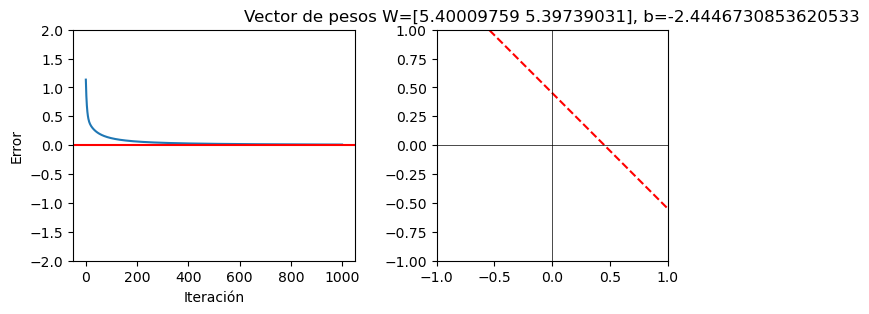

[[1]]


In [88]:
X = np.array([[0, 0, 1, 1], [0, 1, 0, 1]])
Y = np.array([[0, 1, 1, 1]])
f = perceptron_simple(X, Y, alpha=0.5)
print(f(np.array([[1], [1]])))

### Compuerta AND

En una forma similar, podemos entrenar al perceptrón para detectar cuando los dos nodos de entrada se activan al mismo tiempo. Esto puede ser visto como la función booleana AND. En este caso, los vectores de entrenamiento y de salida esperada pueden ser:

$$\begin{split}
\pmb{X_1} = \begin{pmatrix} 0 \\ 0 \end{pmatrix} & \pmb{Y_1} = \begin{pmatrix} 0 \end{pmatrix} \\
\pmb{X_2} = \begin{pmatrix} 0 \\ 1 \end{pmatrix} & \pmb{Y_2} = \begin{pmatrix} 0 \end{pmatrix} \\
\pmb{X_3} = \begin{pmatrix} 1 \\ 0 \end{pmatrix} & \pmb{Y_3} = \begin{pmatrix} 0\end{pmatrix} \\
\pmb{X_4} = \begin{pmatrix} 1 \\ 1 \end{pmatrix} & \pmb{Y_4} = \begin{pmatrix} 1 \end{pmatrix}
\end{split}$$

Para hacerlo con nuestro código, no tenemos más que entrenar al perceptrón con las nuevas matrices:

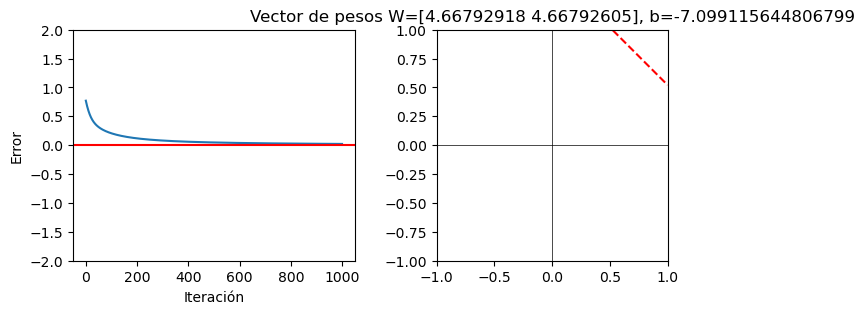

[[1]]


In [89]:
X = np.array([[0, 0, 1, 1], 
              [0, 1, 0, 1]])
Y = np.array([[0, 0, 0, 1]])
f = perceptron_simple(X, Y, alpha=0.5)
print(f(np.array([[1], [1]])))

### Compuerta XOR

Veamos ahora la compuerta XOR. Esta compuerta, también conocida como compuerta OR exclusiva, detecta cuando una entrada esta activa, pero no la otra. Para resolver este caso, los vectores de entrenamiento y de salida esperada pueden ser:

$$\begin{split}
\pmb{X_1} = \begin{pmatrix} 0 \\ 0 \end{pmatrix} & \pmb{Y_1} = \begin{pmatrix} 0 \end{pmatrix} \\
\pmb{X_2} = \begin{pmatrix} 0 \\ 1 \end{pmatrix} & \pmb{Y_2} = \begin{pmatrix} 1 \end{pmatrix} \\
\pmb{X_3} = \begin{pmatrix} 1 \\ 0 \end{pmatrix} & \pmb{Y_3} = \begin{pmatrix} 1 \end{pmatrix} \\
\pmb{X_3} = \begin{pmatrix} 1 \\ 1 \end{pmatrix} & \pmb{Y_4} = \begin{pmatrix} 0 \end{pmatrix}
\end{split}$$

Este problema de apariencia inocente es difícil porque no es linealmente separable. Si ponemos las cuatro posibles entradas en un plano, no hay ninguna línea recta que separe los casos que tienen que dar 1 de los casos que tienen que dar 0. 
Vamos a comparar a una red de 2 entradas y una salida que entrenamos con la regla delta y a una red que como la presentada más arriba, además de las 2 entradas y la salida tiene dos unidades en la capa oculta.

*Ejercicio: Entrenar al perceptrón con estos vectores de entrenamiento y de salida esperados.*

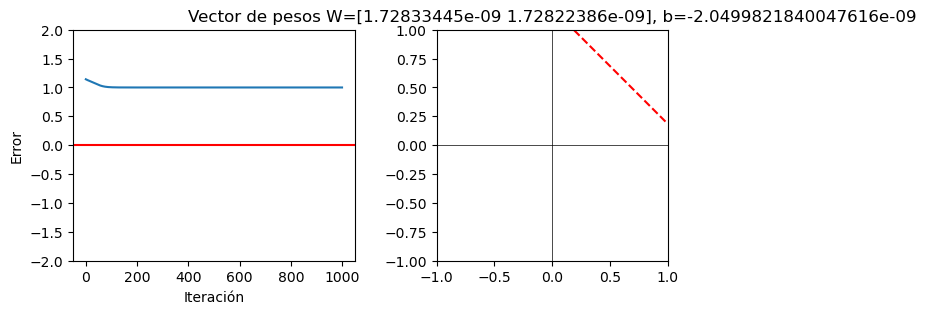

<function __main__.perceptron_simple.<locals>.<lambda>(X)>

In [91]:
# Entrenamos al perceptrón para la funcion XOR
perceptron_simple(X=np.array([[0, 0, 1, 1], [0, 1, 0, 1]]), Y=np.array([[0, 1, 1, 0]]))

Resulta que no es posible construir un perceptrón que compute la operación lógica XOR. Minsky y Papert (1969) demostraron varios teoremas sobre los perceptrones de una sola capa, algunos de los cuales indicaron sus limitadas capacidades de clasificación de patrones y aproximación de funciones. Por ejemplo, demostraron que el perceptrón de una sola capa no podía implementar la función lógica de exclusión OR y varios otros predicados similares.

La intuición detrás de este resultado importante se basa en entender que un perceptrón es un clasificador lineal. Para una entrada bidimensional $x_1$ y $x_2$, la ecuación del perceptrón

$$w_1 \times x_1 + w_2 \times x_2 + b = 0$$

es la ecuación de una línea.

Esta línea actúa como un límite de decisión en un espacio bidimensional, donde la salida 0 se asigna a todas las entradas que se encuentran de un lado de la línea, y la salida 1 a todos los puntos de entrada que están del otro lado de la línea. Si tuviéramos más de 2 entradas, el límite de decisión se convertiría en un hiperplano en lugar de una línea, pero la idea es la misma: separar el espacio en dos categorías.

Decimos que XOR no es una función linealmente separable. Por supuesto, podríamos dibujar un límite con una curva, o alguna otra función, pero no con una sola línea.

## Perceptrón multicapa

Los resultados de Minsky y Papert no se aplicaban a los perceptrones multicapa. Paul Werbos presentó un procedimiento general convergente para ajustar de manera adaptativa los pesos de un sistema no lineal diferenciable, con el fin de aprender una relación funcional entre las entradas y salidas del sistema. El procedimiento calcula las derivadas de alguna función de las salidas, respecto a todas las entradas y pesos o parámetros del sistema, trabajando de atrás hacia adelante, desde las salidas a las entradas. Este algoritmo, conocido como retropropagación del error o simplemente retropropagación, ajusta de manera adaptativa los pesos para realizar una correcta clasificación de patrones utilizando descenso por gradiente y muestras de entrenamiento. Propaga las derivadas desde la capa de salida a través de cada capa intermedia de la red de perceptrones multicapa.

El perceptrón multicapa agrega una capa oculta $h$ (por *hidden*) conformada por un número arbitrario de nodos y ubicados entre los nodos de entrada y salida del perceptrón. Los nodos de salida del perceptrón ya no estarán conectados directamente a los nodos de entrada, sino que recibirán como entrada el resultado de la capa oculta.

El perceptrón multicapa tendra que aprender dos matrices de pesos, $\pmb{W_h}$ y $\pmb{W_r}$, y dos factores de sesgo $b_h$ y $b_r$, de forma tal que la salida del perceptrón, definida como:

$$\text{\~{y}} = r = \sigma(W_r \cdot \sigma(W_h \cdot X + b_h) + b_r)$$

se aproxime cada vez más a la salida esperada.

In [32]:
# Definimos la funcion que entrena un conjunto de datos de entrada y salida y grafica el error cometido
# en cada salto de tiempo.
# X: Las entradas del conjunto de entrenamiento
# Y: Las salidas esperadas del conjunto de entrenamiento
# nodos_capa_oculta: Cantidad de nodos en la capa oculta
# tmax: Tiempo máximo que queremos entrenar
# alpha: Constante de aprendizaje
def perceptron_multicapa(X, Y, nodos_capa_oculta=4, alpha=0.5):
    # Definimos la cantidad de trials que vamos a usar
    tmax = 1000
    t = np.arange(tmax)

    # Iniciamos un array que va a guardar los errores en cada paso para poder graficarlos al final
    # y observar como va aprendiendo el perceptrón en cada paso
    errors = []

    # Fijamos la semilla para reproducir siempre los mismos valores aleatorios
    np.random.seed(1) 

    # Iniciamos la matriz con los pesos de la capa de salida en forma aleatoria
    W_r = np.random.randn(Y.shape[0], nodos_capa_oculta)

    # Iniciamos la matriz con los pesos de la capa oculta en forma aleatoria
    W_h = np.random.randn(nodos_capa_oculta, X.shape[0])

    # Iniciamos los términos de sesgo para la capta de salida y la capa oculta con números aleatorios
    b_r = np.random.uniform(-1, 1)
    b_h = np.random.uniform(-1, 1)

    for step in t:       
        h = y(X, W_h, b_h)
        a_h = g(h)
        
        z = y(a_h, W_r, b_r)
        a_r = g(z)
        
        r = a_r

        error = loss(Y, r)
        
        delta_r = error * dg(a_r)
        delta_h = W_r.T.dot(delta_r) * dg(a_h)
        
        W_h = W_h + alpha * delta_h.dot(X.T)
        W_r = W_r + alpha * delta_r.dot(a_h.T)
        
        b_r = b_r + alpha * delta_r.sum()
        b_h = b_h + alpha * delta_h.sum()

        errors = np.append(errors, np.sum(np.pow(error, 2)))

    # Graficamos el error
    plt.plot(t, errors)
    plt.ylim(-2, 2)
    plt.hlines(y=0, xmin=0, xmax=tmax, color='r', linestyles='--')
    plt.show()

    return (W_h, b_h, W_r, b_r)

# Entrenamos al perceptrón para la funcion OR, tm
@widgets.interact(nodos_capa_oculta=(1, 8), alpha=(0, 2, 0.1))
def simulate(nodos_capa_oculta=4, alpha=0.5):
    X = np.array([[0, 0, 1, 1], [0, 1, 0, 1]])
    Y = np.array([[0, 1, 1, 0]])
    W_h, b_h, W_r, b_r = perceptron_multicapa(X, Y, nodos_capa_oculta, alpha)

interactive(children=(IntSlider(value=4, description='nodos_capa_oculta', max=8, min=1), FloatSlider(value=0.5…

Imprimimos los pesos y factores de sesgo resultantes para la capa oculta y la capa de salida:

In [11]:
print(f"W_h: {W_h}")
print(f"b_h: {b_h}")
print(f"W_r: {W_r}")
print(f"b_r: {b_r}")

W_h: [[-6.30384715 -6.69001441]
 [-3.65971188  3.28922817]
 [-2.63066635 -2.06652631]
 [-3.10334784 -1.8273012 ]]
b_h: 3.4506193921882886
W_r: [[-8.35152148 -4.59618867  3.67765522  6.58543586]]
b_r: -0.5932244456876655


Ejercitamos la red aprendida con un conjunto de entradas:

In [12]:
print(np.where(g(y(g(y(np.array([[0], [1]]), W_h, b_h)), W_r, b_r)) < threshold, 0, 1))

[[1]]


*Ejercicio: Pruebe resolver el mismo conjunto de entrenamiento variando la cantidad de nodos en la capa oculta*

Se ha demostrado que las redes neuronales *feedforward* multicapa con un número suficiente de unidades ocultas entre las unidades de entrada y salida tienen una propiedad de aproximación universal: "pueden aproximar prácticamente cualquier función de interés con el grado de precisión deseado" (Hornik et al. 1989).

## MNIST Dataset

In [5]:
# !pip install scikit-learn
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
digits = np.eye(10)
X = np.array(mnist.data / 255.0)
Y = np.array([digits[y] for y in mnist.target.astype(int)])
digits

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [6]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [15]:
X[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

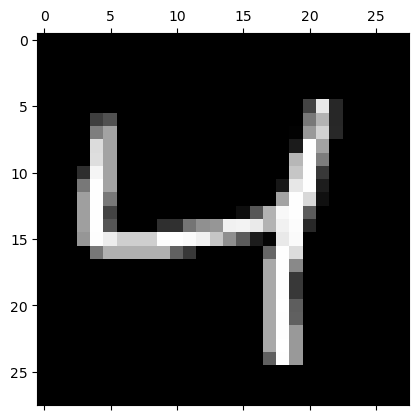

In [104]:
plt.matshow(X[2].reshape(28, 28), cmap='gray')

In [17]:
Y

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [18]:
Y[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

*Ejercicio: Vea como luce el dígito en la posicion 4 y que valor deberia tener según nuestro dataset*

In [19]:
X.shape

(70000, 784)

In [20]:
Y.shape

(70000, 10)

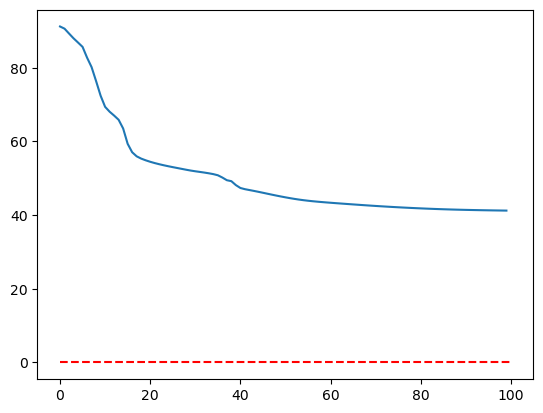

In [18]:
import scipy

# Redefinimos la función de activación para que no falle para valores muy chicos o muy grandes
def g(y):
    return 1 / (1 + np.exp(-y))
    #return scipy.special.expit(y)

# Definimos la funcion que entrena un conjunto de datos de entrada y salida y grafica el error cometido
# en cada salto de tiempo.
# X: Las entradas del conjunto de entrenamiento
# Y: Las salidas esperadas del conjunto de entrenamiento
# nodos_capa_oculta: Cantidad de nodos en la capa oculta
# tmax: Tiempo máximo que queremos entrenar
# alpha: Constante de aprendizaje
def perceptron_multicapa(X, Y, nodos_capa_oculta=4, tmax=2000, alpha=0.5):
    # Definimos la cantidad de trials que vamos a usar
    t = np.arange(tmax)

    # Iniciamos un array que va a guardar los errores en cada paso para poder graficarlos al final
    # y observar como va aprendiendo el perceptrón en cada paso
    errors = []

    # Iniciamos la matriz con los pesos de la capa de salida en forma aleatoria
    W_r = np.random.randn(Y.shape[0], nodos_capa_oculta)

    # Iniciamos la matriz con los pesos de la capa oculta en forma aleatoria
    W_h = np.random.randn(nodos_capa_oculta, X.shape[0])

    # Iniciamos los términos de sesgo para la capta de salida y la capa oculta con números aleatorios
    b_r = np.random.uniform(-1, 1)
    b_h = np.random.uniform(-1, 1)

    for step in t:
        for batch in range (70):
            Xtrain=X[:,batch*100:(batch+1)*100]
            Ytrain=Y[:,batch*100:(batch+1)*100]

            h = y(Xtrain, W_h, b_h)
            a_h = g(h)
            
            z = y(a_h, W_r, b_r)
            a_r = g(z)
            
            r = a_r
    
            error = loss(Ytrain, r)
            
            delta_r = error * dg(a_r)
            delta_h = W_r.T.dot(delta_r) * dg(a_h)
            
            W_h = W_h + alpha * delta_h.dot(Xtrain.T)
            W_r = W_r + alpha * delta_r.dot(a_h.T)
            
            b_r = b_r + alpha * delta_r.sum()
            b_h = b_h + alpha * delta_h.sum()
    
        errors = np.append(errors, np.sum(np.pow(error, 2)))

    # Graficamos el error
    plt.plot(t, errors)
    
    plt.hlines(y=0, xmin=0, xmax=tmax, color='r', linestyles='--')

    return (W_h, b_h, W_r, b_r)

# Entrenamos al perceptrón para la funcion OR, tm
W_h, b_h, W_r, b_r = perceptron_multicapa(X.T, Y.T, nodos_capa_oculta=128, tmax=100, alpha=0.01)

In [19]:
r = g(y(g(y(np.array([X[2]]).T, W_h, b_h)), W_r, b_r))
print(np.where(r==np.max(r), 1, 0))


[[0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]]


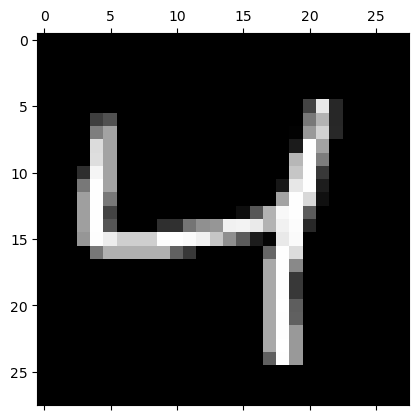

In [20]:
plt.matshow(X[2].reshape(28, 28), cmap='gray')